# SN II Template

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import piscola

In [2]:
info_df = pd.read_csv('templates/m15_du_sch_mlt1_FeC_mix0p4_list', 
                      names=['file', 'phase'], delim_whitespace=True)

columns = ['wave', 'flux']
df_list = []
for file, phase in info_df.values:
    temp_file = os.path.join('templates', f'{file}.fl')
    epoch_df = pd.read_csv(temp_file, names=columns, delim_whitespace=True)
    epoch_df['phase'] = phase
    df_list.append(epoch_df)
init_sed_df = pd.concat(df_list)
init_sed_df = init_sed_df[(init_sed_df.wave >= 1000) & (init_sed_df.wave <= 12000)]  # remove most of the UV and IR 

In [3]:
# linearly interpolate to a common wavelength array taking the first epoch as reference 
phase_df0 = init_sed_df[init_sed_df.phase==init_sed_df.phase.values[0]]
wave0 = phase_df0.wave.values

interp_list = []
for phase in init_sed_df.phase.unique():
    phase_df = init_sed_df[init_sed_df.phase==phase]
    interp_flux = np.interp(wave0, phase_df.wave.values, phase_df.flux.values)
    interp_df = pd.DataFrame({'wave':wave0, 'flux':interp_flux, 'phase':phase})
    interp_list.append(interp_df)
    
sed_df = pd.concat(interp_list)

Template from: https://www-n.oca.eu/supernova/sn2p/ccsn_systematics.html

## SED template

This SN II SED template has phases with respect to explosion epoch 

,wave,flux,phase
0,1000.017,3.615977e-08,11.72
1,1000.101,3.651035e-08,11.72
2,1000.184,3.684889e-08,11.72
3,1000.269,3.714225e-08,11.72
4,1000.353,3.735473e-08,11.72


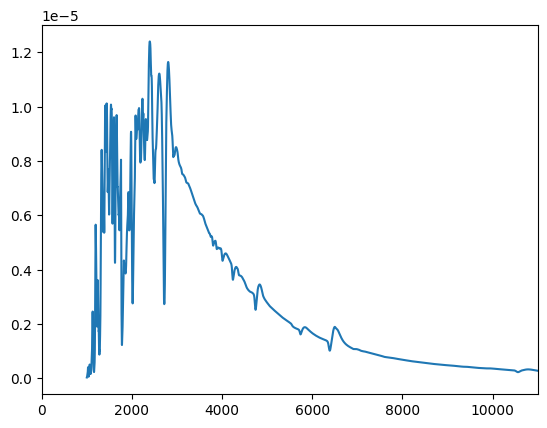

In [4]:
phase_df = sed_df[sed_df.phase==11.72]
plt.plot(phase_df.wave, phase_df.flux)
plt.xlim(0, 11000);
sed_df.head()

## B-band peak

Let's get offset of the template phase to estimate a new phase with respect to B-band peak

In [5]:
Bessell_B = piscola.filters_class.SingleFilter('Bessell_B', 'VEGA')

fluxes_B = []
for phase in sed_df.phase.unique():
    phase_df = sed_df[sed_df.phase==phase]
    flux = Bessell_B.integrate_filter(phase_df.wave.values, phase_df.flux.values)
    fluxes_B.append(flux)
fluxes_B = np.array(fluxes_B)

Text(0.5, 1.0, 'B-band light curve')

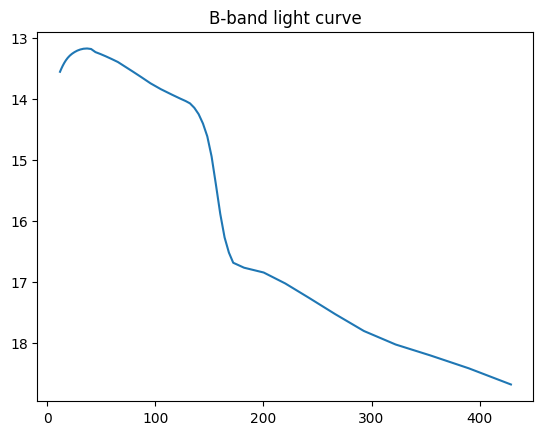

In [6]:
plt.plot(sed_df.phase.unique(), -2.5*np.log10(fluxes_B))
plt.gca().invert_yaxis()
plt.title('B-band light curve')

In [7]:
peak_id = np.argmax(fluxes_B)
peak_offset = sed_df.phase.unique()[peak_id]
peak_offset

36.8

## Interpolate SED

In [33]:
interp_dict = {'phase':np.empty(0),
               'wave':np.empty(0),
               'flux':np.empty(0),
              }

waves = sed_df.wave.unique()[::10]  # pick every 10 wavelengths as this array is too long
interp_phases = np.arange(-26, 280)

for wave in waves:
    lc_df = sed_df[sed_df.wave==wave]
    lc_phase, lc_flux = lc_df.phase.values- peak_offset, lc_df.flux.values
    interp_flux = np.interp(interp_phases, lc_phase, lc_flux)
    
    interp_wave = np.array([wave]*len(interp_phases))
    interp_dict['phase'] = np.append(interp_dict['phase'], interp_phases)
    interp_dict['wave'] = np.append(interp_dict['wave'], interp_wave)
    interp_dict['flux'] = np.append(interp_dict['flux'], interp_flux)
    
interp_df = pd.DataFrame(interp_dict)
interp_df.sort_values(['phase', 'wave'], inplace=True)
# apply offset to phase to have epochs with respect to B-band peak
# instead of epochs with respect to explosion epoch
interp_df.phase = interp_df.phase.values 

Plot the result

,phase,wave,flux
0,-26.0,1000.017,3.615977e-08
306,-26.0,1000.859,3.853204e-08
612,-26.0,1001.709,4.194438e-08
918,-26.0,1002.557,4.541981e-08
1224,-26.0,1003.407,4.920487e-08


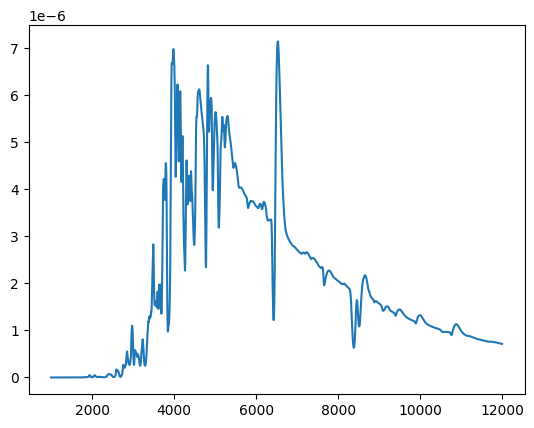

In [34]:
# SED
phase_df = interp_df[interp_df.phase==20]
plt.plot(phase_df.wave, phase_df.flux);
interp_df.head()

Text(0.5, 1.0, 'B-band light curve')

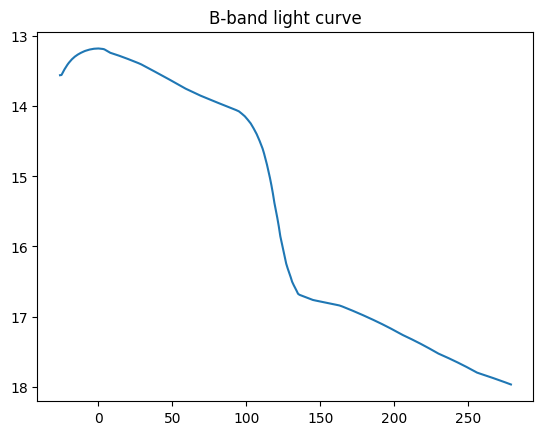

In [35]:
# Light curve
Bessell_B = piscola.filters_class.SingleFilter('Bessell_B', 'VEGA')

fluxes_B = []
for phase in interp_df.phase.unique():
    phase_df = interp_df[interp_df.phase==phase]
    flux = Bessell_B.integrate_filter(phase_df.wave.values, phase_df.flux.values)
    fluxes_B.append(flux)
fluxes_B = np.array(fluxes_B)

plt.plot(interp_df.phase.unique(), -2.5*np.log10(fluxes_B))
plt.gca().invert_yaxis()
plt.title('B-band light curve')

## Output

Save the template for PISCOLA to read and create a README file

In [36]:
interp_df.to_csv('sed_template.dat', index=False, sep='\t', header=False)

In [37]:
readme = """This template is a modified version of the Dessart SN IIP m15mlt1 template
taken from https://www-n.oca.eu/supernova/sn2p/ccsn_systematics.html.

The original template is linearly interpolated in time and
the phases are shifted such that the Bessell-B-band light-curve
peak is taken as phase 0 (zero).
"""

In [38]:
with open('README.txt', 'w') as file:
    file.write(readme)